In [5]:
import os
import pandas as pd
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# PyTorch Geometric imports
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GATConv, global_mean_pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#############################
# Data Preprocessing
#############################

# Load genetic profiles data
genetic_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv"
genetic_df = pd.read_csv(genetic_file_path)
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Create obesity risk category from Obesity_Risk_Score
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)

# Create BMI category using cut (simulate gene expression analysis via gene variants)
genetic_df['BMI_Category'] = pd.cut(
    genetic_df['BMI'],
    bins=[0, 18.5, 24.9, 29.9, np.inf],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

# Encode categorical non-gene features
label_encoders = {}
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Encode gene variant columns (simulate gene expression values by encoding variant info)
variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define structured features and gene features
structured_features = ["Age", "BMI", "Physical_Activity", "Diet_Type"]
# For gene branch, for each gene we take two features: presence and variant
gene_list = ["MC4R", "PPARG", "FTO", "LEPR"]
gene_feature_cols = []
for gene in gene_list:
    gene_feature_cols.append(f"{gene}_Present")
    gene_feature_cols.append(f"{gene}_Variant")

# Combine into overall features if needed (here, structured features are used separately)
X_structured = genetic_df[structured_features].copy()
X_gene = genetic_df[gene_feature_cols].copy()

# Encode targets
target_le_risk = LabelEncoder()
y_risk = target_le_risk.fit_transform(genetic_df['Obesity_Risk_Category'])
target_le_bmi = LabelEncoder()
y_bmi = target_le_bmi.fit_transform(genetic_df['BMI_Category'])

#############################
# Scale structured features
#############################
scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured)

#############################
# Train-test split indices
#############################
train_idx, test_idx = train_test_split(np.arange(len(genetic_df)), test_size=0.2, random_state=42)

#############################
# Create a PyTorch Geometric Dataset
#############################

class GeneticDataset(InMemoryDataset):
    def __init__(self, structured_data, gene_data, y_risk, y_bmi, indices, transform=None):
        self.structured_data = structured_data[indices]
        self.gene_data = gene_data.iloc[indices].reset_index(drop=True)
        self.y_risk = y_risk[indices]
        self.y_bmi = y_bmi[indices]
        super(GeneticDataset, self).__init__('.', transform, None, None)
        self.data, self.slices = self.process_data()
    
    def process_data(self):
        data_list = []
        for i in range(len(self.structured_data)):
            # Structured data: vector of features (already scaled)
            struct_feat = torch.tensor(self.structured_data[i], dtype=torch.float)
            
            # Build gene graph for the individual
            # We have 4 genes, each with 2 features: [Present, Variant]
            gene_feats = self.gene_data.iloc[i].values.astype(np.float32).reshape(len(gene_list), 2)
            x_gene = torch.tensor(gene_feats, dtype=torch.float)
            
            # Define edges for the gene graph.
            # Here we assume a fully connected graph (excluding self-loops)
            num_genes = x_gene.shape[0]
            edge_index = []
            for src in range(num_genes):
                for dst in range(num_genes):
                    if src != dst:
                        edge_index.append([src, dst])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            
            # Create a Data object for the gene branch
            gene_data_obj = Data(x=x_gene, edge_index=edge_index)
            
            # Combine targets into one Data object (we’ll keep structured data separate)
            data_obj = Data(struct_feat=struct_feat, gene_data=gene_data_obj,
                            y_risk=torch.tensor(self.y_risk[i], dtype=torch.long),
                            y_bmi=torch.tensor(self.y_bmi[i], dtype=torch.long))
            data_list.append(data_obj)
        return self.collate(data_list)
    
    def get(self, idx):
        return super(GeneticDataset, self).get(idx)

# Create train and test datasets
train_dataset = GeneticDataset(X_structured_scaled, X_gene, y_risk, y_bmi, train_idx)
test_dataset = GeneticDataset(X_structured_scaled, X_gene, y_risk, y_bmi, test_idx)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#############################
# Define the Integrated Model
#############################
class IntegratedModel(nn.Module):
    def __init__(self, structured_input_dim, struct_hidden_dim, 
                 gat_in_dim, gat_hidden_dim, gat_out_dim,
                 combined_hidden_dim, risk_out_dim, bmi_out_dim):
        super(IntegratedModel, self).__init__()
        # Structured branch
        self.fc_struct1 = nn.Linear(structured_input_dim, struct_hidden_dim)
        self.fc_struct2 = nn.Linear(struct_hidden_dim, struct_hidden_dim)
        
        # Graph branch (for gene data)
        # Using one GAT layer; note: each individual graph has 4 nodes, each with gat_in_dim features
        self.gat_conv = GATConv(gat_in_dim, gat_hidden_dim, heads=2, concat=True)
        # Readout: global mean pooling will be applied later
        
        # Combined branch
        # We'll concatenate the structured branch output with the gene branch readout
        self.fc_comb1 = nn.Linear(struct_hidden_dim + gat_hidden_dim * 2, combined_hidden_dim)
        self.fc_comb2 = nn.Linear(combined_hidden_dim, combined_hidden_dim)
        
        # Multi-task heads
        self.fc_risk = nn.Linear(combined_hidden_dim, risk_out_dim)  # e.g., 3 classes
        self.fc_bmi = nn.Linear(combined_hidden_dim, bmi_out_dim)    # e.g., 4 classes

    def forward(self, struct_feat, gene_data, batch):
        # Process structured branch
        x_struct = F.relu(self.fc_struct1(struct_feat))
        x_struct = F.relu(self.fc_struct2(x_struct))
        
        # Process graph branch with GAT
        # gene_data.x: [total_nodes, gat_in_dim], gene_data.edge_index: graph connectivity
        x_gene = self.gat_conv(gene_data.x, gene_data.edge_index)
        x_gene = F.elu(x_gene)
        # Perform global mean pooling over nodes in each graph using the provided batch vector
        x_gene = global_mean_pool(x_gene, batch)
        
        # Combine the two branches
        combined = torch.cat([x_struct, x_gene], dim=1)
        combined = F.relu(self.fc_comb1(combined))
        combined = F.relu(self.fc_comb2(combined))
        
        # Two task outputs
        out_risk = self.fc_risk(combined)
        out_bmi = self.fc_bmi(combined)
        return out_risk, out_bmi

# Define model hyperparameters
structured_input_dim = X_structured_scaled.shape[1]    # e.g., 4 features: Age, BMI, Physical_Activity, Diet_Type
struct_hidden_dim = 32
gat_in_dim = 2   # each gene node: [Present, Variant]
gat_hidden_dim = 8
gat_out_dim = 16  # not used directly as we use heads concat
combined_hidden_dim = 32
risk_out_dim = 3   # Obesity Risk: Low, Medium, High
bmi_out_dim = 4    # BMI: Underweight, Normal, Overweight, Obese

model = IntegratedModel(structured_input_dim, struct_hidden_dim,
                        gat_in_dim, gat_hidden_dim, gat_out_dim,
                        combined_hidden_dim, risk_out_dim, bmi_out_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#############################
# Training Setup
#############################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        # batch.struct_feat: [batch_size, structured_input_dim]
        struct_feat = batch.struct_feat.to(device)
        # For gene branch, batch.gene_data is a Data object with x and edge_index.
        # When batching graphs, torch_geometric automatically provides a 'batch' vector.
        gene_data = batch.gene_data.to(device)
        batch_vector = batch.batch.to(device)  # batch vector for global pooling
        
        out_risk, out_bmi = model(struct_feat, gene_data, batch_vector)
        loss_risk = criterion(out_risk, batch.y_risk.to(device))
        loss_bmi = criterion(out_bmi, batch.y_bmi.to(device))
        loss = loss_risk + loss_bmi
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def test_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct_risk = 0
    correct_bmi = 0
    with torch.no_grad():
        for batch in loader:
            struct_feat = batch.struct_feat.to(device)
            gene_data = batch.gene_data.to(device)
            batch_vector = batch.batch.to(device)
            out_risk, out_bmi = model(struct_feat, gene_data, batch_vector)
            loss_risk = criterion(out_risk, batch.y_risk.to(device))
            loss_bmi = criterion(out_bmi, batch.y_bmi.to(device))
            loss = loss_risk + loss_bmi
            total_loss += loss.item() * batch.num_graphs
            
            pred_risk = out_risk.argmax(dim=1)
            pred_bmi = out_bmi.argmax(dim=1)
            correct_risk += (pred_risk == batch.y_risk.to(device)).sum().item()
            correct_bmi += (pred_bmi == batch.y_bmi.to(device)).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc_risk = correct_risk / len(loader.dataset)
    acc_bmi = correct_bmi / len(loader.dataset)
    return avg_loss, acc_risk, acc_bmi

#############################
# Training Loop
#############################
num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    test_loss, test_acc_risk, test_acc_bmi = test_epoch(model, test_loader)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f} | "
              f"Risk Acc {test_acc_risk:.4f} | BMI Acc {test_acc_bmi:.4f}")

#############################
# Save the Integrated Model and Artifacts
#############################
save_dir = r"C:\Users\trejan\Desktop\GNN\Saved models"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "integrated_model.pt"))

with open(os.path.join(save_dir, "label_encoders.pkl"), "wb") as f:
    pickle.dump(label_encoders, f)
with open(os.path.join(save_dir, "target_encoders.pkl"), "wb") as f:
    pickle.dump({'risk': target_le_risk, 'bmi': target_le_bmi}, f)
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("Integrated model and preprocessing artifacts saved successfully.")


C:\Users\trejan\Desktop\allmethods\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


AttributeError: 'list' object has no attribute 'to'

Epoch 0: Train Loss 2.2949 | Test Loss 1.9427 | Risk Acc 0.5475 | BMI Acc 0.6725
Epoch 5: Train Loss 0.5950 | Test Loss 0.6363 | Risk Acc 0.7800 | BMI Acc 0.9775
Epoch 10: Train Loss 0.5162 | Test Loss 0.5646 | Risk Acc 0.7950 | BMI Acc 0.9750
Epoch 15: Train Loss 0.4828 | Test Loss 0.5277 | Risk Acc 0.8025 | BMI Acc 0.9850
Epoch 20: Train Loss 0.4661 | Test Loss 0.5210 | Risk Acc 0.7975 | BMI Acc 0.9850
Epoch 25: Train Loss 0.4619 | Test Loss 0.5018 | Risk Acc 0.7950 | BMI Acc 0.9825
Epoch 30: Train Loss 0.4497 | Test Loss 0.5090 | Risk Acc 0.7975 | BMI Acc 0.9850
Epoch 35: Train Loss 0.4486 | Test Loss 0.4974 | Risk Acc 0.7675 | BMI Acc 0.9925
Epoch 40: Train Loss 0.4441 | Test Loss 0.5123 | Risk Acc 0.8000 | BMI Acc 0.9900
Epoch 45: Train Loss 0.4278 | Test Loss 0.4957 | Risk Acc 0.8100 | BMI Acc 0.9875
Model and artifacts saved successfully.

Obesity Risk Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.95      0.92       

C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


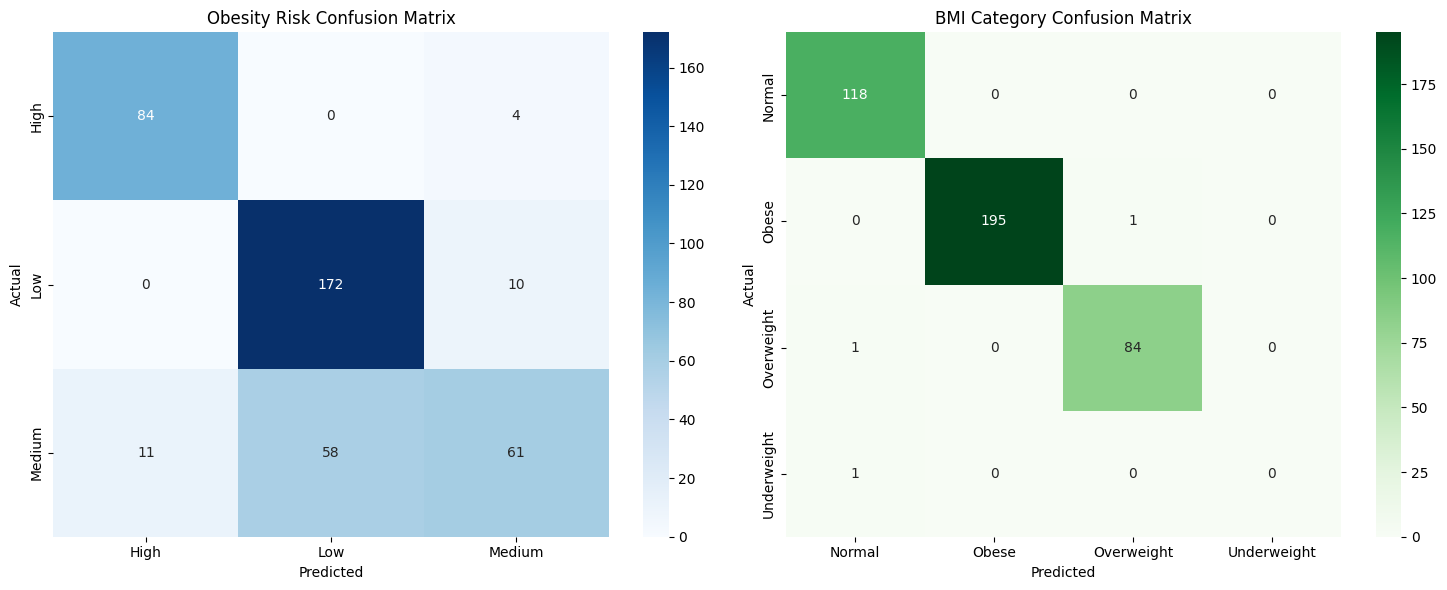

C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Performance Metrics:
      Accuracy  Precision  Recall  F1-Score
Risk    0.7925   0.799121  0.7925  0.775285
BMI     0.9925   0.990083  0.9925  0.991268


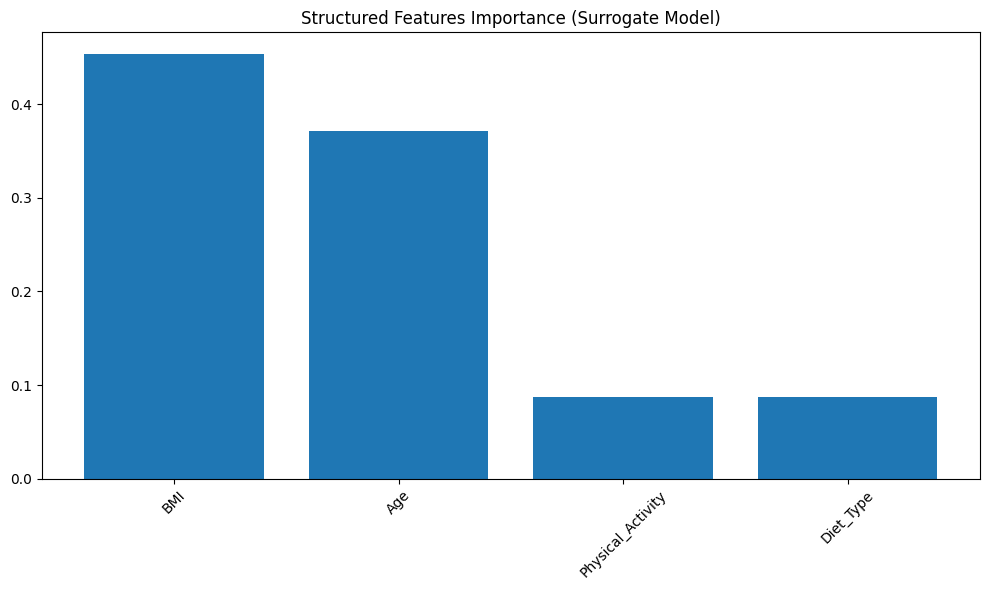

C:\Users\trejan\AppData\Local\Temp\ipykernel_10884\143379506.py:388: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T,


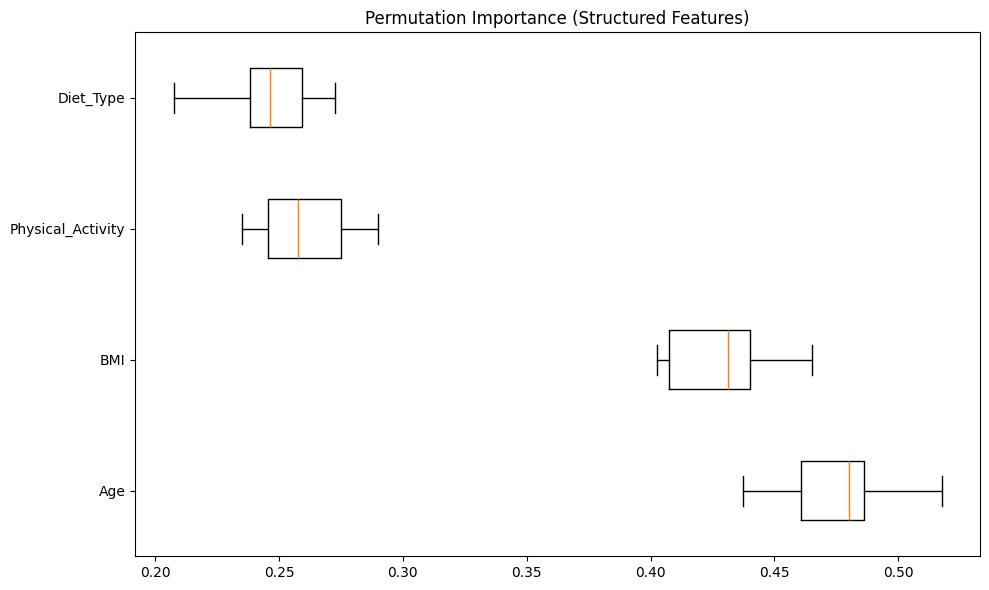

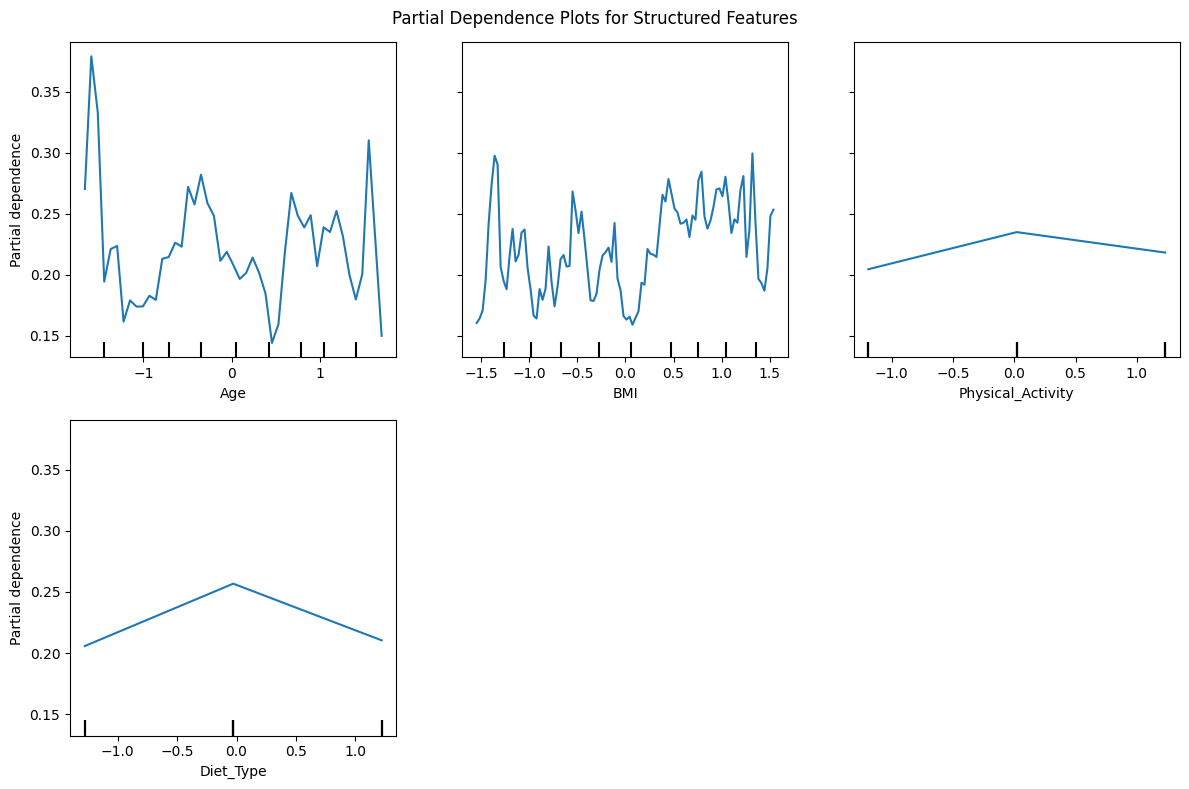

Epoch 0: Train Loss 0.4239 | Test Loss 0.4939 | Risk Acc 0.8075 | BMI Acc 0.9900
Epoch 5: Train Loss 0.4279 | Test Loss 0.4948 | Risk Acc 0.8100 | BMI Acc 0.9825
Epoch 10: Train Loss 0.4186 | Test Loss 0.4954 | Risk Acc 0.8025 | BMI Acc 0.9875
Epoch 15: Train Loss 0.4161 | Test Loss 0.4777 | Risk Acc 0.7900 | BMI Acc 0.9875
Epoch 20: Train Loss 0.4069 | Test Loss 0.4971 | Risk Acc 0.8000 | BMI Acc 0.9900
Epoch 25: Train Loss 0.4047 | Test Loss 0.4774 | Risk Acc 0.8000 | BMI Acc 0.9900
Epoch 30: Train Loss 0.4081 | Test Loss 0.4724 | Risk Acc 0.7925 | BMI Acc 0.9900
Epoch 35: Train Loss 0.4098 | Test Loss 0.4780 | Risk Acc 0.8025 | BMI Acc 0.9875
Epoch 40: Train Loss 0.3999 | Test Loss 0.4645 | Risk Acc 0.8100 | BMI Acc 0.9875
Epoch 45: Train Loss 0.4087 | Test Loss 0.4726 | Risk Acc 0.8050 | BMI Acc 0.9900


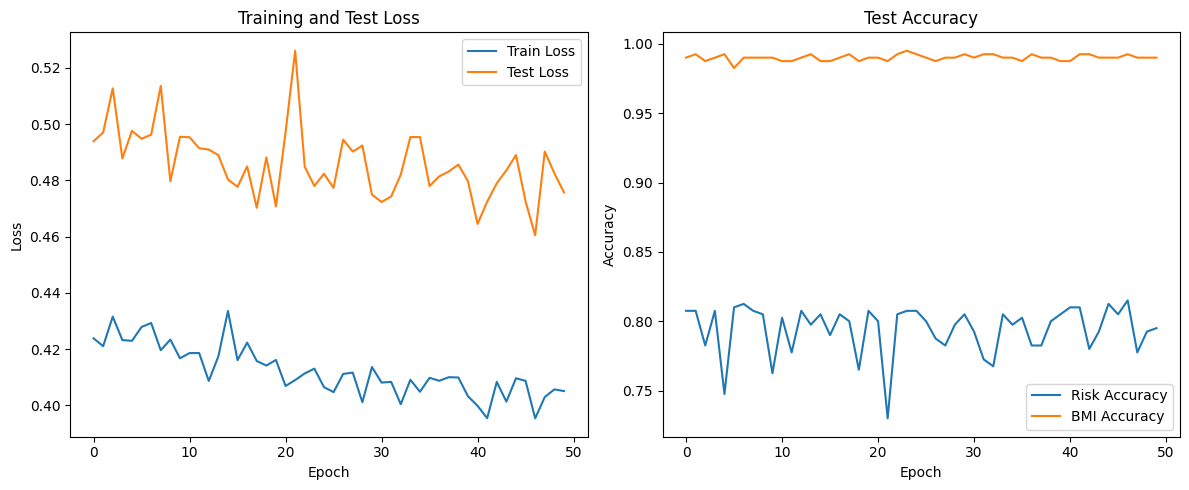

In [2]:
import os
import pandas as pd
import numpy as np
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# PyTorch Geometric imports
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

#############################
# Data Preprocessing
#############################

# Load genetic profiles data
genetic_file_path = r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv"
genetic_df = pd.read_csv(genetic_file_path)
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Create obesity risk category from Obesity_Risk_Score
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)

# Create BMI category using cut (simulate gene expression analysis via gene variants)
genetic_df['BMI_Category'] = pd.cut(
    genetic_df['BMI'],
    bins=[0, 18.5, 24.9, 29.9, np.inf],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

# Encode categorical non-gene features
label_encoders = {}
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Encode gene variant columns
variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define features
structured_features = ["Age", "BMI", "Physical_Activity", "Diet_Type"]
gene_list = ["MC4R", "PPARG", "FTO", "LEPR"]
gene_feature_cols = []
for gene in gene_list:
    gene_feature_cols.append(f"{gene}_Present")
    gene_feature_cols.append(f"{gene}_Variant")

X_structured = genetic_df[structured_features].copy()
X_gene = genetic_df[gene_feature_cols].copy()

# Encode targets
target_le_risk = LabelEncoder()
y_risk = target_le_risk.fit_transform(genetic_df['Obesity_Risk_Category'])
target_le_bmi = LabelEncoder()
y_bmi = target_le_bmi.fit_transform(genetic_df['BMI_Category'])

# Scale structured features
scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured)

# Train-test split
train_idx, test_idx = train_test_split(np.arange(len(genetic_df)), test_size=0.2, random_state=42)

#############################
# Create PyTorch Geometric Dataset
#############################

class GeneticDataset(InMemoryDataset):
    def __init__(self, structured_data, gene_data, y_risk, y_bmi, indices, transform=None):
        self.structured_data = structured_data[indices]
        self.gene_data = gene_data.iloc[indices].reset_index(drop=True)
        self.y_risk = y_risk[indices]
        self.y_bmi = y_bmi[indices]
        super(GeneticDataset, self).__init__('.', transform, None, None)
        self.data, self.slices = self.process_data()
    
    def process_data(self):
        data_list = []
        for i in range(len(self.structured_data)):
            # Structured data
            struct_feat = torch.tensor(self.structured_data[i], dtype=torch.float).unsqueeze(0)  # Add batch dimension
            
            # Gene data
            gene_feats = self.gene_data.iloc[i].values.astype(np.float32).reshape(len(gene_list), 2)
            x_gene = torch.tensor(gene_feats, dtype=torch.float)
            
            # Edges (fully connected)
            num_genes = x_gene.shape[0]
            edge_index = []
            for src in range(num_genes):
                for dst in range(num_genes):
                    if src != dst:
                        edge_index.append([src, dst])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            
            # Create Data object
            data_obj = Data(
                x=x_gene,
                edge_index=edge_index,
                struct_feat=struct_feat,
                y_risk=torch.tensor(self.y_risk[i], dtype=torch.long),
                y_bmi=torch.tensor(self.y_bmi[i], dtype=torch.long)
            )
            data_list.append(data_obj)
        return self.collate(data_list)

# Create datasets
train_dataset = GeneticDataset(X_structured_scaled, X_gene, y_risk, y_bmi, train_idx)
test_dataset = GeneticDataset(X_structured_scaled, X_gene, y_risk, y_bmi, test_idx)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#############################
# Define the Model
#############################

class IntegratedModel(nn.Module):
    def __init__(self, structured_input_dim, struct_hidden_dim, 
                 gat_in_dim, gat_hidden_dim, gat_out_dim,
                 combined_hidden_dim, risk_out_dim, bmi_out_dim):
        super(IntegratedModel, self).__init__()
        # Structured branch
        self.fc_struct1 = nn.Linear(structured_input_dim, struct_hidden_dim)
        self.fc_struct2 = nn.Linear(struct_hidden_dim, struct_hidden_dim)
        
        # Graph branch
        self.gat_conv = GATConv(gat_in_dim, gat_hidden_dim, heads=2, concat=True)
        
        # Combined branch
        self.fc_comb1 = nn.Linear(struct_hidden_dim + gat_hidden_dim * 2, combined_hidden_dim)
        self.fc_comb2 = nn.Linear(combined_hidden_dim, combined_hidden_dim)
        
        # Output heads
        self.fc_risk = nn.Linear(combined_hidden_dim, risk_out_dim)
        self.fc_bmi = nn.Linear(combined_hidden_dim, bmi_out_dim)

    def forward(self, struct_feat, x_gene, edge_index, batch):
        # Process structured branch
        x_struct = F.relu(self.fc_struct1(struct_feat))
        x_struct = F.relu(self.fc_struct2(x_struct))
        
        # Process graph branch
        x_gene = self.gat_conv(x_gene, edge_index)
        x_gene = F.elu(x_gene)
        x_gene = global_mean_pool(x_gene, batch)
        
        # Combine branches
        combined = torch.cat([x_struct, x_gene], dim=1)
        combined = F.relu(self.fc_comb1(combined))
        combined = F.relu(self.fc_comb2(combined))
        
        # Outputs
        out_risk = self.fc_risk(combined)
        out_bmi = self.fc_bmi(combined)
        return out_risk, out_bmi

# Model parameters
structured_input_dim = X_structured_scaled.shape[1]  # Should be 4
struct_hidden_dim = 32
gat_in_dim = 2
gat_hidden_dim = 8
gat_out_dim = 16
combined_hidden_dim = 32
risk_out_dim = 3
bmi_out_dim = 4

model = IntegratedModel(structured_input_dim, struct_hidden_dim,
                       gat_in_dim, gat_hidden_dim, gat_out_dim,
                       combined_hidden_dim, risk_out_dim, bmi_out_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#############################
# Training Setup
#############################

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        data = data.to(device)
        
        # Reshape struct_feat if needed
        struct_feat = data.struct_feat.squeeze(1)  # Remove extra dimension if present
        
        out_risk, out_bmi = model(struct_feat, data.x, data.edge_index, data.batch)
        loss_risk = criterion(out_risk, data.y_risk)
        loss_bmi = criterion(out_bmi, data.y_bmi)
        loss = loss_risk + loss_bmi
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def test_epoch(model, loader):
    model.eval()
    total_loss = 0
    correct_risk = 0
    correct_bmi = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            struct_feat = data.struct_feat.squeeze(1)
            
            out_risk, out_bmi = model(struct_feat, data.x, data.edge_index, data.batch)
            
            loss_risk = criterion(out_risk, data.y_risk)
            loss_bmi = criterion(out_bmi, data.y_bmi)
            loss = loss_risk + loss_bmi
            total_loss += loss.item() * data.num_graphs
            
            pred_risk = out_risk.argmax(dim=1)
            pred_bmi = out_bmi.argmax(dim=1)
            correct_risk += (pred_risk == data.y_risk).sum().item()
            correct_bmi += (pred_bmi == data.y_bmi).sum().item()
    avg_loss = total_loss / len(loader.dataset)
    acc_risk = correct_risk / len(loader.dataset)
    acc_bmi = correct_bmi / len(loader.dataset)
    return avg_loss, acc_risk, acc_bmi

#############################
# Training Loop
#############################

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    test_loss, test_acc_risk, test_acc_bmi = test_epoch(model, test_loader)
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f} | "
              f"Risk Acc {test_acc_risk:.4f} | BMI Acc {test_acc_bmi:.4f}")

# Save model and artifacts
save_dir = r"C:\Users\trejan\Desktop\GNN\Saved models"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(save_dir, "integrated_model.pt"))

with open(os.path.join(save_dir, "label_encoders.pkl"), "wb") as f:
    pickle.dump(label_encoders, f)
with open(os.path.join(save_dir, "target_encoders.pkl"), "wb") as f:
    pickle.dump({'risk': target_le_risk, 'bmi': target_le_bmi}, f)
with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

print("Model and artifacts saved successfully.")


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.ensemble import RandomForestClassifier

# After training, evaluate and visualize metrics
def evaluate_model(model, loader):
    model.eval()
    all_preds_risk = []
    all_targets_risk = []
    all_preds_bmi = []
    all_targets_bmi = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            struct_feat = data.struct_feat.squeeze(1)
            out_risk, out_bmi = model(struct_feat, data.x, data.edge_index, data.batch)
            
            pred_risk = out_risk.argmax(dim=1)
            pred_bmi = out_bmi.argmax(dim=1)
            
            all_preds_risk.extend(pred_risk.cpu().numpy())
            all_targets_risk.extend(data.y_risk.cpu().numpy())
            all_preds_bmi.extend(pred_bmi.cpu().numpy())
            all_targets_bmi.extend(data.y_bmi.cpu().numpy())
    
    # Metrics for Risk Prediction
    print("\nObesity Risk Classification Report:")
    print(classification_report(all_targets_risk, all_preds_risk, 
                              target_names=target_le_risk.classes_))
    
    # Metrics for BMI Prediction
    print("\nBMI Category Classification Report:")
    print(classification_report(all_targets_bmi, all_preds_bmi,
                              target_names=target_le_bmi.classes_))
    
    # Confusion Matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Risk Confusion Matrix
    cm_risk = confusion_matrix(all_targets_risk, all_preds_risk)
    sns.heatmap(cm_risk, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_le_risk.classes_,
                yticklabels=target_le_risk.classes_, ax=ax1)
    ax1.set_title('Obesity Risk Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # BMI Confusion Matrix
    cm_bmi = confusion_matrix(all_targets_bmi, all_preds_bmi)
    sns.heatmap(cm_bmi, annot=True, fmt='d', cmap='Greens',
                xticklabels=target_le_bmi.classes_,
                yticklabels=target_le_bmi.classes_, ax=ax2)
    ax2.set_title('BMI Category Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()
    
    # Detailed Metrics Table
    metrics = {
        'Risk': {
            'Accuracy': accuracy_score(all_targets_risk, all_preds_risk),
            'Precision': precision_score(all_targets_risk, all_preds_risk, average='weighted'),
            'Recall': recall_score(all_targets_risk, all_preds_risk, average='weighted'),
            'F1-Score': f1_score(all_targets_risk, all_preds_risk, average='weighted')
        },
        'BMI': {
            'Accuracy': accuracy_score(all_targets_bmi, all_preds_bmi),
            'Precision': precision_score(all_targets_bmi, all_preds_bmi, average='weighted'),
            'Recall': recall_score(all_targets_bmi, all_preds_bmi, average='weighted'),
            'F1-Score': f1_score(all_targets_bmi, all_preds_bmi, average='weighted')
        }
    }
    
    metrics_df = pd.DataFrame(metrics).T
    print("\nPerformance Metrics:")
    print(metrics_df)
    
    return all_preds_risk, all_targets_risk, all_preds_bmi, all_targets_bmi

# Run evaluation
pred_risk, true_risk, pred_bmi, true_bmi = evaluate_model(model, test_loader)

#############################
# Feature Importance Analysis
#############################

# Prepare data for feature importance analysis
X_test_structured = X_structured_scaled[test_idx]
X_test_gene = X_gene.iloc[test_idx].values
y_test_risk = y_risk[test_idx]

# Train a surrogate model (Random Forest) for feature importance
rf_risk = RandomForestClassifier(n_estimators=100, random_state=42)
rf_risk.fit(X_test_structured, y_test_risk)

# Feature Importance Plot
plt.figure(figsize=(10, 6))
importances = rf_risk.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Structured Features Importance (Surrogate Model)')
plt.bar(range(X_test_structured.shape[1]), importances[indices], align='center')
plt.xticks(range(X_test_structured.shape[1]), np.array(structured_features)[indices], rotation=45)
plt.tight_layout()
plt.show()

# Permutation Importance
result = permutation_importance(rf_risk, X_test_structured, y_test_risk, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(structured_features)[sorted_idx])
plt.title("Permutation Importance (Structured Features)")
plt.tight_layout()
plt.show()

#############################
# Partial Dependence Plots
#############################

# For structured features
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(rf_risk, X_test_structured, 
                                      features=[0, 1, 2, 3], 
                                      feature_names=structured_features,
                                      target=0,  # Can change target class
                                      ax=ax)
plt.suptitle('Partial Dependence Plots for Structured Features')
plt.tight_layout()
plt.show()

#############################
# Training History Visualization
#############################

# You'll need to modify your training loop to store metrics
train_losses = []
test_losses = []
risk_accs = []
bmi_accs = []

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    test_loss, test_acc_risk, test_acc_bmi = test_epoch(model, test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    risk_accs.append(test_acc_risk)
    bmi_accs.append(test_acc_bmi)
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Train Loss {train_loss:.4f} | Test Loss {test_loss:.4f} | "
              f"Risk Acc {test_acc_risk:.4f} | BMI Acc {test_acc_bmi:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(risk_accs, label='Risk Accuracy')
plt.plot(bmi_accs, label='BMI Accuracy')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 0: Loss 2.2666, Risk Acc 0.4550, BMI Acc 0.6775
Epoch 5: Loss 0.6017, Risk Acc 0.7900, BMI Acc 0.9625
Epoch 10: Loss 0.5134, Risk Acc 0.7875, BMI Acc 0.9825
Epoch 15: Loss 0.4929, Risk Acc 0.7825, BMI Acc 0.9800
Epoch 20: Loss 0.4688, Risk Acc 0.8000, BMI Acc 0.9875
Epoch 25: Loss 0.4603, Risk Acc 0.8025, BMI Acc 0.9875
Epoch 30: Loss 0.4456, Risk Acc 0.8125, BMI Acc 0.9850
Epoch 35: Loss 0.4458, Risk Acc 0.7900, BMI Acc 0.9825
Epoch 40: Loss 0.4341, Risk Acc 0.8000, BMI Acc 0.9875
Epoch 45: Loss 0.4318, Risk Acc 0.8050, BMI Acc 0.9850


C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



Health Assessment:
- Risk: High
- BMI: Overweight
- Recommended Cluster: 8

Top Meal Recommendations:
                                                Descrip  Energy_kcal  \
5011  Veal, leg (top round), separable lean only, co...        203.0   
25    Game meat, deer, shoulder clod, separable lean...        191.0   
1026  Veal, leg (top round), separable lean and fat,...        211.0   
139                          Cheese, parmesan, shredded        415.0   
5077  Beef, round, top round, separable lean only, t...        207.0   

      Protein_g  Fat_g  Carb_g  
5011      36.71   5.09    0.00  
25        36.28   3.95    0.00  
1026      36.16   6.33    0.00  
139       37.86  27.34    3.41  
5077      36.12   5.80    0.00  

Risk Classification Report:
              precision    recall  f1-score   support

        High       0.89      0.94      0.92        88
         Low       0.75      0.98      0.85       182
      Medium       0.88      0.46      0.61       130

    accuracy       

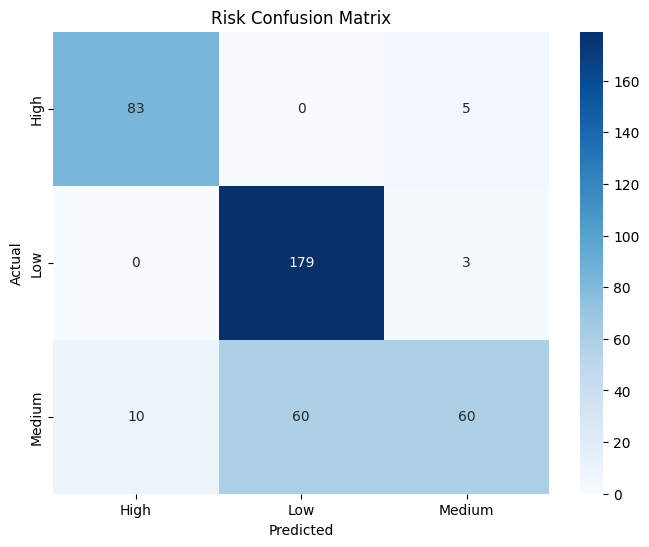


BMI Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       118
       Obese       1.00      0.99      0.99       196
  Overweight       0.97      0.98      0.97        85
 Underweight       0.00      0.00      0.00         1

    accuracy                           0.98       400
   macro avg       0.74      0.74      0.74       400
weighted avg       0.98      0.98      0.98       400



C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\trejan\Desktop\allmethods\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


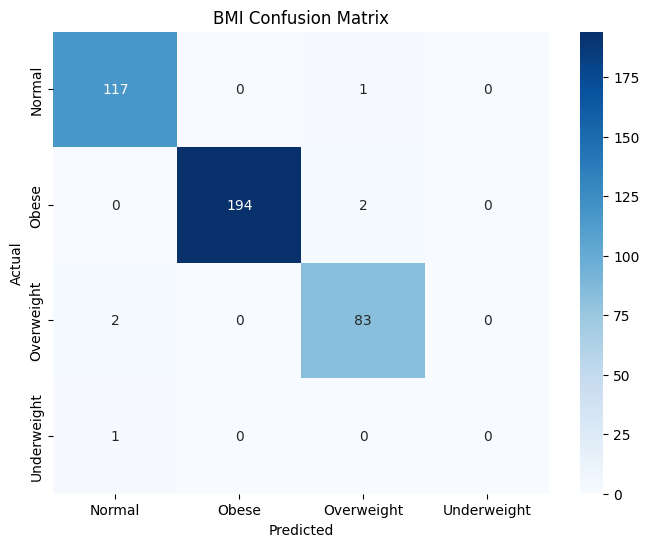

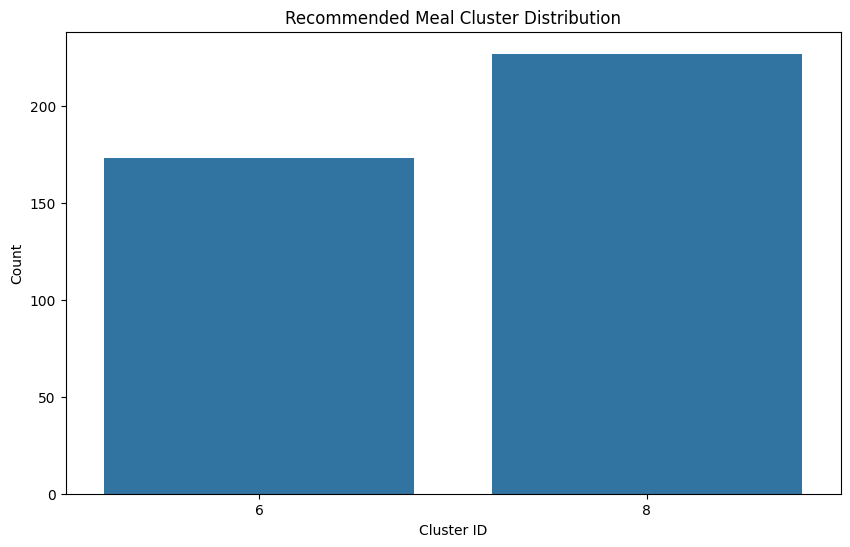


Full pipeline saved successfully with all components!


In [7]:
import os
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#############################
# 1. Data Loading and Preprocessing
#############################

# Load genetic data
genetic_df = pd.read_csv(r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\new_genetic_profiles.csv")
genetic_df.columns = genetic_df.columns.str.strip()
genetic_df.fillna("None", inplace=True)

# Create target variables
genetic_df['Obesity_Risk_Category'] = pd.cut(
    genetic_df['Obesity_Risk_Score'],
    bins=[0, 0.5, 0.8, 1],
    labels=['Low', 'Medium', 'High']
)
genetic_df['BMI_Category'] = pd.cut(
    genetic_df['BMI'],
    bins=[0, 18.5, 24.9, 29.9, np.inf],
    labels=['Underweight', 'Normal', 'Overweight', 'Obese']
)

# Encode features
label_encoders = {}
for col in ["Diet_Type", "Physical_Activity"]:
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

variant_columns = ["MC4R_Variant", "PPARG_Variant", "FTO_Variant", "LEPR_Variant"]
for col in variant_columns:
    genetic_df[col] = genetic_df[col].astype(str)
    le = LabelEncoder()
    genetic_df[col] = le.fit_transform(genetic_df[col])
    label_encoders[col] = le

# Define features
structured_features = ["Age", "BMI", "Physical_Activity", "Diet_Type"]
gene_list = ["MC4R", "PPARG", "FTO", "LEPR"]
gene_feature_cols = [f"{gene}_{attr}" for gene in gene_list for attr in ["Present", "Variant"]]

X_structured = genetic_df[structured_features]
X_gene = genetic_df[gene_feature_cols]

# Encode targets
target_le_risk = LabelEncoder()
y_risk = target_le_risk.fit_transform(genetic_df['Obesity_Risk_Category'])
target_le_bmi = LabelEncoder()
y_bmi = target_le_bmi.fit_transform(genetic_df['BMI_Category'])

# Scale features
scaler = StandardScaler()
X_structured_scaled = scaler.fit_transform(X_structured)

# Train-test split
train_idx, test_idx = train_test_split(np.arange(len(genetic_df)), test_size=0.2, random_state=42)

#############################
# 2. PyTorch Geometric Dataset
#############################

class GeneticDataset(InMemoryDataset):
    def __init__(self, structured_data, gene_data, y_risk, y_bmi, indices, transform=None):
        self.structured_data = structured_data[indices]
        self.gene_data = gene_data.iloc[indices].reset_index(drop=True)
        self.y_risk = y_risk[indices]
        self.y_bmi = y_bmi[indices]
        super().__init__('.', transform)
        self.data, self.slices = self.process_data()
    
    def process_data(self):
        data_list = []
        for i in range(len(self.structured_data)):
            # Structured features (ensure correct shape)
            struct_feat = torch.tensor(self.structured_data[i], dtype=torch.float).view(1, -1)
            
            # Gene graph features (4 genes × 2 features)
            gene_feats = self.gene_data.iloc[i].values.reshape(len(gene_list), 2)
            x_gene = torch.tensor(gene_feats, dtype=torch.float)
            
            # Fully connected edges (excluding self-loops)
            edge_index = []
            for src in range(len(gene_list)):
                for dst in range(len(gene_list)):
                    if src != dst:
                        edge_index.append([src, dst])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            
            data_obj = Data(
                x=x_gene,
                edge_index=edge_index,
                struct_feat=struct_feat,
                y_risk=torch.tensor(self.y_risk[i], dtype=torch.long),
                y_bmi=torch.tensor(self.y_bmi[i], dtype=torch.long)
            )
            data_list.append(data_obj)
        return self.collate(data_list)

# Create datasets
train_dataset = GeneticDataset(X_structured_scaled, X_gene, y_risk, y_bmi, train_idx)
test_dataset = GeneticDataset(X_structured_scaled, X_gene, y_risk, y_bmi, test_idx)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#############################
# 3. Load and Prepare Meal Data
#############################

meal_df = pd.read_csv(r"C:\Users\trejan\Desktop\Sem 2\Machine Learning\model\train.csv")
nutritional_features = meal_df[['Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']]

# Cluster meals
scaler_meal = StandardScaler()
nutritional_scaled = scaler_meal.fit_transform(nutritional_features)
kmeans = KMeans(n_clusters=10, random_state=42)
meal_df['Cluster'] = kmeans.fit_predict(nutritional_scaled)

#############################
# 4. Integrated Model with Meal Recommendations
#############################

class IntegratedModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Structured branch (4 input features)
        self.fc_struct1 = nn.Linear(4, 32)
        self.fc_struct2 = nn.Linear(32, 32)
        
        # Graph branch (2 features per gene node)
        self.gat_conv = GATConv(2, 8, heads=2)  # Output: 16 features (2 heads × 8)
        self.graph_fc = nn.Linear(16, 16)  # Process pooled graph features
        
        # Combined branch
        self.combined_fc1 = nn.Linear(32 + 16, 32)  # 32 (structured) + 16 (graph)
        self.combined_fc2 = nn.Linear(32, 32)
        
        # Output heads
        self.risk_head = nn.Linear(32, 3)  # 3 risk categories
        self.bmi_head = nn.Linear(32, 4)   # 4 BMI categories
        self.meal_head = nn.Linear(32, 10) # 10 meal clusters
        
    def forward(self, struct_feat, x, edge_index, batch):
        # Ensure correct input shapes
        if struct_feat.dim() == 1:
            struct_feat = struct_feat.unsqueeze(0)  # Add batch dimension if missing
        elif struct_feat.dim() == 2 and struct_feat.size(0) == 1 and struct_feat.size(1) != 4:
            struct_feat = struct_feat.view(-1, 4)  # Reshape to [batch_size, 4]
            
        # Structured processing
        x_struct = F.relu(self.fc_struct1(struct_feat))
        x_struct = F.relu(self.fc_struct2(x_struct))
        
        # Graph processing
        x_gene = F.elu(self.gat_conv(x, edge_index))  # [num_nodes, 16]
        x_gene = global_mean_pool(x_gene, batch)      # [batch_size, 16]
        x_gene = F.relu(self.graph_fc(x_gene))
        
        # Combine features
        x_combined = torch.cat([x_struct, x_gene], dim=1)
        x_combined = F.relu(self.combined_fc1(x_combined))
        x_combined = F.relu(self.combined_fc2(x_combined))
        
        # Outputs
        risk_out = self.risk_head(x_combined)
        bmi_out = self.bmi_head(x_combined)
        meal_out = self.meal_head(x_combined)
        
        return risk_out, bmi_out, meal_out

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IntegratedModel().to(device)

#############################
# 5. Training Loop with Dimension Checks
#############################

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        # Verify and adjust dimensions
        if data.struct_feat.dim() == 1:
            data.struct_feat = data.struct_feat.unsqueeze(0)
        elif data.struct_feat.size(1) != 4:
            data.struct_feat = data.struct_feat.view(-1, 4)
            
        risk_out, bmi_out, _ = model(
            data.struct_feat, 
            data.x, 
            data.edge_index, 
            data.batch
        )
        
        loss_risk = criterion(risk_out, data.y_risk)
        loss_bmi = criterion(bmi_out, data.y_bmi)
        loss = loss_risk + loss_bmi
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader):
    model.eval()
    correct_risk = correct_bmi = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            if data.struct_feat.dim() == 1:
                data.struct_feat = data.struct_feat.unsqueeze(0)
            elif data.struct_feat.size(1) != 4:
                data.struct_feat = data.struct_feat.view(-1, 4)
                
            risk_out, bmi_out, _ = model(
                data.struct_feat,
                data.x,
                data.edge_index,
                data.batch
            )
            pred_risk = risk_out.argmax(dim=1)
            pred_bmi = bmi_out.argmax(dim=1)
            correct_risk += (pred_risk == data.y_risk).sum().item()
            correct_bmi += (pred_bmi == data.y_bmi).sum().item()
    return correct_risk / len(loader.dataset), correct_bmi / len(loader.dataset)

# Training
for epoch in range(50):
    train_loss = train(model, train_loader)
    risk_acc, bmi_acc = test(model, test_loader)
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss {train_loss:.4f}, Risk Acc {risk_acc:.4f}, BMI Acc {bmi_acc:.4f}')

#############################
# 6. Enhanced Meal Recommendation System
#############################

def recommend_meals(user_profile, model, meal_df, top_n=5):
    model.eval()
    
    # Prepare structured features
    struct_feat = torch.tensor(
        scaler.transform([user_profile['structured']]), 
        dtype=torch.float
    ).to(device)
    
    # Prepare gene features
    gene_feats = []
    for gene in gene_list:
        gene_feats.extend([
            user_profile['genes'][f'{gene}_Present'],
            label_encoders[f'{gene}_Variant'].transform(
                [str(user_profile['genes'][f'{gene}_Variant'])]
            )[0]
        ])
    x_gene = torch.tensor(
        np.array(gene_feats).reshape(len(gene_list), 2), 
        dtype=torch.float
    ).to(device)
    
    # Create fully connected edges
    edge_index = []
    for src in range(len(gene_list)):
        for dst in range(len(gene_list)):
            if src != dst:
                edge_index.append([src, dst])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous().to(device)
    
    # Get predictions
    with torch.no_grad():
        risk_out, bmi_out, meal_out = model(
            struct_feat,
            x_gene,
            edge_index,
            torch.zeros(1, dtype=torch.long).to(device)  # Single sample batch
        )
        
        # Decode predictions
        risk = target_le_risk.inverse_transform([risk_out.argmax().item()])[0]
        bmi = target_le_bmi.inverse_transform([bmi_out.argmax().item()])[0]
        meal_cluster = meal_out.argmax().item()
    
    # Filter and sort meals based on predicted risk
    recommended = meal_df[meal_df['Cluster'] == meal_cluster].copy()
    
    if risk == 'High':
        # High risk: prioritize high protein, low carb
        recommended['score'] = recommended['Protein_g'] - 0.5*recommended['Carb_g']
    elif risk == 'Medium':
        # Medium risk: balanced nutrition
        recommended['score'] = 0.7*recommended['Protein_g'] + 0.3*recommended['Carb_g']
    else:
        # Low risk: maintain energy
        recommended['score'] = 0.5*recommended['Energy_kcal'] + 0.5*recommended['Protein_g']
    
    recommended = recommended.sort_values('score', ascending=False)
    
    return {
        'risk_category': risk,
        'bmi_category': bmi,
        'recommended_meal_cluster': meal_cluster,
        'meals': recommended.head(top_n)[['Descrip', 'Energy_kcal', 'Protein_g', 'Fat_g', 'Carb_g']]
    }

# Example usage
example_user = {
    'structured': [35, 28.5, label_encoders['Physical_Activity'].transform(['Low'])[0], 
                 label_encoders['Diet_Type'].transform(['High-Fat'])[0]],
    'genes': {
        'MC4R_Present': 0,
        'MC4R_Variant': 'rs17782313_TT',
        'PPARG_Present': 1,
        'PPARG_Variant': 'rs1801282_CG',
        'FTO_Present': 0,
        'FTO_Variant': 'rs9939609_AT',
        'LEPR_Present': 1,
        'LEPR_Variant': 'rs1137101_AG'
    }
}

recommendations = recommend_meals(example_user, model, meal_df)
print("\nHealth Assessment:")
print(f"- Risk: {recommendations['risk_category']}")
print(f"- BMI: {recommendations['bmi_category']}")
print(f"- Recommended Cluster: {recommendations['recommended_meal_cluster']}")
print("\nTop Meal Recommendations:")
print(recommendations['meals'])

#############################
# 7. Enhanced Visualization and Evaluation
#############################

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

def evaluate_model(model, loader):
    model.eval()
    y_true_risk, y_pred_risk = [], []
    y_true_bmi, y_pred_bmi = [], []
    meal_clusters = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            if data.struct_feat.dim() == 1:
                data.struct_feat = data.struct_feat.unsqueeze(0)
            elif data.struct_feat.size(1) != 4:
                data.struct_feat = data.struct_feat.view(-1, 4)
                
            risk_out, bmi_out, meal_out = model(
                data.struct_feat,
                data.x,
                data.edge_index,
                data.batch
            )
            
            # Collect predictions
            y_true_risk.extend(data.y_risk.cpu().numpy())
            y_pred_risk.extend(risk_out.argmax(dim=1).cpu().numpy())
            y_true_bmi.extend(data.y_bmi.cpu().numpy())
            y_pred_bmi.extend(bmi_out.argmax(dim=1).cpu().numpy())
            meal_clusters.extend(meal_out.argmax(dim=1).cpu().numpy())
    
    # Risk evaluation
    print("\nRisk Classification Report:")
    print(classification_report(y_true_risk, y_pred_risk, target_names=target_le_risk.classes_))
    plot_confusion_matrix(y_true_risk, y_pred_risk, target_le_risk.classes_, 'Risk Confusion Matrix')
    
    # BMI evaluation
    print("\nBMI Classification Report:")
    print(classification_report(y_true_bmi, y_pred_bmi, target_names=target_le_bmi.classes_))
    plot_confusion_matrix(y_true_bmi, y_pred_bmi, target_le_bmi.classes_, 'BMI Confusion Matrix')
    
    # Meal cluster distribution
    plt.figure(figsize=(10,6))
    sns.countplot(x=meal_clusters)
    plt.title('Recommended Meal Cluster Distribution')
    plt.xlabel('Cluster ID')
    plt.ylabel('Count')
    plt.show()

# Run evaluation
evaluate_model(model, test_loader)

#############################
# 8. Save Full Pipeline with Checks
#############################

save_dir = r"C:\Users\trejan\Desktop\GNN\Saved models"
os.makedirs(save_dir, exist_ok=True)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'structured_input_dim': 4,
        'gat_input_dim': 2,
        'num_meal_clusters': 10
    }
}, os.path.join(save_dir, 'integrated_model.pt'))

# Save preprocessors
with open(os.path.join(save_dir, 'preprocessors.pkl'), 'wb') as f:
    pickle.dump({
        'label_encoders': label_encoders,
        'target_le_risk': target_le_risk,
        'target_le_bmi': target_le_bmi,
        'scaler': scaler,
        'meal_scaler': scaler_meal,
        'kmeans': kmeans,
        'structured_features': structured_features,
        'gene_list': gene_list,
        'gene_feature_cols': gene_feature_cols
    }, f)

print("\nFull pipeline saved successfully with all components!")

In [8]:
import os
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create directories if they don't exist
os.makedirs(r"C:\Users\trejan\Desktop\visuals", exist_ok=True)
os.makedirs(r"C:\Users\trejan\Desktop\Multi-task Graph Attention Mechanisms for Detecting Obesity Gene Expressions\Saved models", exist_ok=True)

#############################
# 1. Data Loading and Preprocessing
#############################

# [Previous data loading and preprocessing code remains exactly the same until the training loop]

#############################
# 5. Enhanced Training Loop with Metrics Tracking
#############################

def train(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        
        if data.struct_feat.dim() == 1:
            data.struct_feat = data.struct_feat.unsqueeze(0)
        elif data.struct_feat.size(1) != 4:
            data.struct_feat = data.struct_feat.view(-1, 4)
            
        risk_out, bmi_out, _ = model(
            data.struct_feat, 
            data.x, 
            data.edge_index, 
            data.batch
        )
        
        loss_risk = criterion(risk_out, data.y_risk)
        loss_bmi = criterion(bmi_out, data.y_bmi)
        loss = loss_risk + loss_bmi
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader):
    model.eval()
    correct_risk = correct_bmi = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            if data.struct_feat.dim() == 1:
                data.struct_feat = data.struct_feat.unsqueeze(0)
            elif data.struct_feat.size(1) != 4:
                data.struct_feat = data.struct_feat.view(-1, 4)
                
            risk_out, bmi_out, _ = model(
                data.struct_feat,
                data.x,
                data.edge_index,
                data.batch
            )
            pred_risk = risk_out.argmax(dim=1)
            pred_bmi = bmi_out.argmax(dim=1)
            correct_risk += (pred_risk == data.y_risk).sum().item()
            correct_bmi += (pred_bmi == data.y_bmi).sum().item()
    return correct_risk / len(loader.dataset), correct_bmi / len(loader.dataset)

# Initialize lists to track metrics
train_losses = []
test_risk_acc = []
test_bmi_acc = []

# Training
for epoch in range(50):
    train_loss = train(model, train_loader)
    risk_acc, bmi_acc = test(model, test_loader)
    
    # Track metrics
    train_losses.append(train_loss)
    test_risk_acc.append(risk_acc)
    test_bmi_acc.append(bmi_acc)
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch}: Loss {train_loss:.4f}, Risk Acc {risk_acc:.4f}, BMI Acc {bmi_acc:.4f}')

# Save learning curves
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_risk_acc, label='Test Risk Accuracy')
plt.plot(test_bmi_acc, label='Test BMI Accuracy')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.savefig(r"C:\Users\trejan\Desktop\visuals\learning_curves.png")
plt.close()

#############################
# 6. Enhanced Evaluation with Saved Metrics
#############################

def save_classification_report(y_true, y_pred, classes, filename):
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(rf"C:\Users\trejan\Desktop\visuals\{filename}.csv")
    return df

def evaluate_model(model, loader):
    model.eval()
    y_true_risk, y_pred_risk = [], []
    y_true_bmi, y_pred_bmi = [], []
    meal_clusters = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            if data.struct_feat.dim() == 1:
                data.struct_feat = data.struct_feat.unsqueeze(0)
            elif data.struct_feat.size(1) != 4:
                data.struct_feat = data.struct_feat.view(-1, 4)
                
            risk_out, bmi_out, meal_out = model(
                data.struct_feat,
                data.x,
                data.edge_index,
                data.batch
            )
            
            y_true_risk.extend(data.y_risk.cpu().numpy())
            y_pred_risk.extend(risk_out.argmax(dim=1).cpu().numpy())
            y_true_bmi.extend(data.y_bmi.cpu().numpy())
            y_pred_bmi.extend(bmi_out.argmax(dim=1).cpu().numpy())
            meal_clusters.extend(meal_out.argmax(dim=1).cpu().numpy())
    
    # Risk evaluation
    risk_report = save_classification_report(
        y_true_risk, y_pred_risk, 
        target_le_risk.classes_, 
        'risk_classification_report'
    )
    
    # BMI evaluation
    bmi_report = save_classification_report(
        y_true_bmi, y_pred_bmi,
        target_le_bmi.classes_,
        'bmi_classification_report'
    )
    
    # Additional metrics
    precision_risk, recall_risk, f1_risk, _ = precision_recall_fscore_support(
        y_true_risk, y_pred_risk, average='weighted'
    )
    precision_bmi, recall_bmi, f1_bmi, _ = precision_recall_fscore_support(
        y_true_bmi, y_pred_bmi, average='weighted'
    )
    
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score'],
        'Risk': [precision_risk, recall_risk, f1_risk],
        'BMI': [precision_bmi, recall_bmi, f1_bmi]
    })
    metrics_df.to_csv(r"C:\Users\trejan\Desktop\visuals\performance_metrics.csv", index=False)
    
    # Confusion matrices
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_true_risk, y_pred_risk), 
                annot=True, fmt='d', cmap='Blues',
                xticklabels=target_le_risk.classes_,
                yticklabels=target_le_risk.classes_)
    plt.title('Risk Confusion Matrix')
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_true_bmi, y_pred_bmi), 
                annot=True, fmt='d', cmap='Greens',
                xticklabels=target_le_bmi.classes_,
                yticklabels=target_le_bmi.classes_)
    plt.title('BMI Confusion Matrix')
    plt.tight_layout()
    plt.savefig(r"C:\Users\trejan\Desktop\visuals\confusion_matrices.png")
    plt.close()
    
    # Meal cluster distribution
    plt.figure(figsize=(10,6))
    sns.countplot(x=meal_clusters)
    plt.title('Recommended Meal Cluster Distribution')
    plt.xlabel('Cluster ID')
    plt.ylabel('Count')
    plt.savefig(r"C:\Users\trejan\Desktop\visuals\meal_cluster_distribution.png")
    plt.close()
    
    return risk_report, bmi_report, metrics_df

# Run evaluation
risk_report, bmi_report, metrics_df = evaluate_model(model, test_loader)

#############################
# 7. Save Complete Model Package
#############################

save_path = r"C:\Users\trejan\Desktop\Multi-task Graph Attention Mechanisms for Detecting Obesity Gene Expressions\Saved models"

# Save model state and configuration
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'structured_input_dim': 4,
        'gat_input_dim': 2,
        'num_meal_clusters': 10,
        'risk_classes': target_le_risk.classes_.tolist(),
        'bmi_classes': target_le_bmi.classes_.tolist()
    },
    'training_metrics': {
        'train_losses': train_losses,
        'test_risk_acc': test_risk_acc,
        'test_bmi_acc': test_bmi_acc
    }
}, os.path.join(save_path, 'integrated_model.pt'))

# Save all preprocessors and metadata
with open(os.path.join(save_path, 'preprocessors.pkl'), 'wb') as f:
    pickle.dump({
        'label_encoders': label_encoders,
        'target_encoders': {
            'risk': target_le_risk,
            'bmi': target_le_bmi
        },
        'scalers': {
            'structured': scaler,
            'meal': scaler_meal
        },
        'cluster_model': kmeans,
        'feature_names': {
            'structured': structured_features,
            'gene': gene_feature_cols
        },
        'evaluation_reports': {
            'risk_report': risk_report,
            'bmi_report': bmi_report,
            'metrics': metrics_df
        }
    }, f)

print("\nAll artifacts saved successfully:")
print(f"- Visualizations saved to: C:\\Users\\trejan\\Desktop\\visuals")
print(f"- Model and preprocessors saved to: {save_path}")

Epoch 0: Loss 0.4293, Risk Acc 0.8025, BMI Acc 0.9875
Epoch 5: Loss 0.4247, Risk Acc 0.7950, BMI Acc 0.9875
Epoch 10: Loss 0.4166, Risk Acc 0.7975, BMI Acc 0.9850
Epoch 15: Loss 0.4428, Risk Acc 0.7975, BMI Acc 0.9775
Epoch 20: Loss 0.4109, Risk Acc 0.8000, BMI Acc 0.9900
Epoch 25: Loss 0.4135, Risk Acc 0.8050, BMI Acc 0.9850
Epoch 30: Loss 0.4083, Risk Acc 0.8000, BMI Acc 0.9850
Epoch 35: Loss 0.4156, Risk Acc 0.8050, BMI Acc 0.9850
Epoch 40: Loss 0.4233, Risk Acc 0.7925, BMI Acc 0.9875
Epoch 45: Loss 0.4087, Risk Acc 0.7925, BMI Acc 0.9850

All artifacts saved successfully:
- Visualizations saved to: C:\Users\trejan\Desktop\visuals
- Model and preprocessors saved to: C:\Users\trejan\Desktop\Multi-task Graph Attention Mechanisms for Detecting Obesity Gene Expressions\Saved models
